In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "SBP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn016511,MEEVGAQVAPPIFMHQNLGGRFCEGHSMTKKRGQPNFHHQQPRLTS...,916,1
1,Achn017541,MGSVSGSSSYGGQGMKGDFSVDLKLGHVVNAGNESTDNLQVPSVPK...,319,1
2,Achn039041,MDWDWDLTELGQEDLVGSSSLEAHKNGGGFSVELKLGGLGDLGDGS...,376,1
3,Achn064091,MGSGSSSSSDSLHGLKFGHKIYFDDSGGGGPPSASALGGRPPAAAP...,349,1
4,Achn082431,MDPPTPPPPPPLSDMENPIPHYDDPLWNWSDFLDFGIDAEAQFSIS...,849,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
581,0.004822,0.0,0.002893,0.001929,0.000964,0.005786,0.000964,0.000964,0.002893,0.006750,...,0.002893,0.000964,0.00000,0.000964,0.001929,0.000964,0.001929,0.000000,0.0,0.001929
580,0.001972,0.0,0.001972,0.003945,0.001972,0.003945,0.000000,0.000000,0.000000,0.005917,...,0.000000,0.000000,0.00000,0.000000,0.003945,0.001972,0.001972,0.000000,0.0,0.000000
463,0.000000,0.0,0.000000,0.002849,0.000000,0.008547,0.000000,0.000000,0.005698,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.008547,0.000000,0.000000,0.000000,0.0,0.000000
4218,0.019277,0.0,0.000000,0.007229,0.000000,0.007229,0.002410,0.000000,0.007229,0.004819,...,0.002410,0.002410,0.00241,0.007229,0.000000,0.004819,0.000000,0.002410,0.0,0.000000
4564,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003788,0.000000,0.007576,0.011364,...,0.000000,0.003788,0.00000,0.000000,0.000000,0.000000,0.000000,0.003788,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6648, 441)
X_test: (1663, 441)
y_train: (6648,)
y_test: (1663,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:10 849ms/step - accuracy: 0.4062 - loss: 0.6932

10/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4892 - loss: 0.6929    

19/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5249 - loss: 0.6920

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5850 - loss: 0.6871

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6381 - loss: 0.6694

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6733 - loss: 0.6404

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6912 - loss: 0.6196 - val_accuracy: 0.9617 - val_loss: 0.1164


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9531 - loss: 0.1267

20/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.1014 

38/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.0980

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.0957

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9657 - loss: 0.0953

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9659 - loss: 0.0951

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9659 - loss: 0.0951 - val_accuracy: 0.9850 - val_loss: 0.0595


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.0781

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9562 - loss: 0.1088 

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9624 - loss: 0.0987

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9660 - loss: 0.0921

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9691 - loss: 0.0865

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0820

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.0790

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.0788 - val_accuracy: 0.9895 - val_loss: 0.0514


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.2446

14/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9768 - loss: 0.1120 

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.0878

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9821 - loss: 0.0771

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9833 - loss: 0.0707

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0667

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0635

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0621 - val_accuracy: 0.9865 - val_loss: 0.0545


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9531 - loss: 0.0752

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9855 - loss: 0.0332 

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.0317

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9892 - loss: 0.0321

54/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9895 - loss: 0.0323

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0322

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0328

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0329 - val_accuracy: 0.9835 - val_loss: 0.0604


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0145

14/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0269 

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0299

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0301

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0300

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9923 - loss: 0.0307

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0313

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0315 - val_accuracy: 0.9789 - val_loss: 0.0624


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9688 - loss: 0.0859

12/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9796 - loss: 0.0567 

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9826 - loss: 0.0505

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.0471

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.0459

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9858 - loss: 0.0443

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9862 - loss: 0.0431

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0426 - val_accuracy: 0.9774 - val_loss: 0.0824


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0084

14/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.0927 

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9617 - loss: 0.0934

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9622 - loss: 0.0923

39/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9653 - loss: 0.0856

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9685 - loss: 0.0783

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9710 - loss: 0.0723

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0673

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9738 - loss: 0.0656 - val_accuracy: 0.9857 - val_loss: 0.0545


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9844 - loss: 0.0432

16/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0221 

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0250

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0245

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0244

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0244 - val_accuracy: 0.9827 - val_loss: 0.0585


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0057

11/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0146 

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.0216

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0229

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0229

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0231

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.9556 - val_loss: 0.1420


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0254

13/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.0466 

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.0471

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0448

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0425

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0406

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0391

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0388 - val_accuracy: 0.9857 - val_loss: 0.0562


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0071

13/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0180 

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9957 - loss: 0.0182

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0185

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0193

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9949 - loss: 0.0196

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9948 - loss: 0.0200

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0200 - val_accuracy: 0.9865 - val_loss: 0.0572


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0050

14/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0177 

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0170

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0174

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0177

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0180

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0180

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0179 - val_accuracy: 0.9872 - val_loss: 0.0550



[Train Accuracy: 99.53% - Test Accuracy: 98.02%]


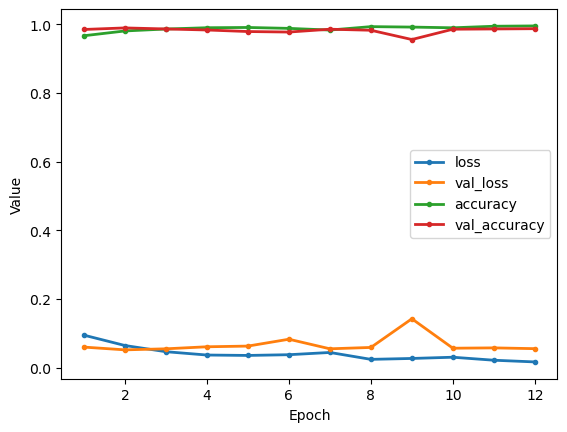

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
581,0.000000,0.0,0.0,0.000000,0.0,0.000965,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000965,0.0,0.000965,0.0,0.0,0.0
580,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
463,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4218,0.004831,0.0,0.0,0.002415,0.0,0.002415,0.0,0.0,0.0,0.002415,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4564,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6648, 8869)
X_test: (1663, 8869)
y_train: (6648,)
y_test: (1663,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,270,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,985 (8.83 MB)

 Trainable params: 2,313,985 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:14 901ms/step - accuracy: 0.6250 - loss: 0.6931

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5353 - loss: 0.6934   

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5193 - loss: 0.6933

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5140 - loss: 0.6929

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5105 - loss: 0.6923

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5098 - loss: 0.6914

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5110 - loss: 0.6901

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5169 - loss: 0.6882

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5242 - loss: 0.6855

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5332 - loss: 0.6818

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5434 - loss: 0.6771

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5487 - loss: 0.6744

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5543 - loss: 0.6714

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5655 - loss: 0.6648

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5768 - loss: 0.6574

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5878 - loss: 0.6492

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5986 - loss: 0.6404

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6089 - loss: 0.6311

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6188 - loss: 0.6214

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6283 - loss: 0.6115

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6374 - loss: 0.6016

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6459 - loss: 0.5917

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6540 - loss: 0.5821 - val_accuracy: 0.9925 - val_loss: 0.0281


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9844 - loss: 0.0634

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9876 - loss: 0.0430

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9884 - loss: 0.0436

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9898 - loss: 0.0400

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9909 - loss: 0.0370

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9913 - loss: 0.0358

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9916 - loss: 0.0347

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9919 - loss: 0.0338

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9921 - loss: 0.0330

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9923 - loss: 0.0325

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9924 - loss: 0.0320

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9926 - loss: 0.0315

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9927 - loss: 0.0308

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9929 - loss: 0.0302

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9931 - loss: 0.0296

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9932 - loss: 0.0291

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9933 - loss: 0.0286

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9934 - loss: 0.0283

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9935 - loss: 0.0281

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9935 - loss: 0.0280

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9935 - loss: 0.0280

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9935 - loss: 0.0279 - val_accuracy: 0.9857 - val_loss: 0.0425


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 0.0051

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9906 - loss: 0.0160

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9913 - loss: 0.0174

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9923 - loss: 0.0170

17/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9929 - loss: 0.0164

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9935 - loss: 0.0158

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9939 - loss: 0.0154

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9942 - loss: 0.0149

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9945 - loss: 0.0145

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9948 - loss: 0.0140

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9950 - loss: 0.0137

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9952 - loss: 0.0133

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9954 - loss: 0.0129

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9956 - loss: 0.0126

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9958 - loss: 0.0123

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9959 - loss: 0.0119

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9961 - loss: 0.0117

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9962 - loss: 0.0115

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9963 - loss: 0.0114

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9964 - loss: 0.0112

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9965 - loss: 0.0110

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9966 - loss: 0.0109

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9966 - loss: 0.0108 - val_accuracy: 0.9940 - val_loss: 0.0242


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 0.0019

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0016

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0018

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0017

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0017

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0018

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0018

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9997 - loss: 0.0018

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9997 - loss: 0.0018

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9997 - loss: 0.0017

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9997 - loss: 0.0019

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9996 - loss: 0.0021

47/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0023

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0024

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0025

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0027

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9995 - loss: 0.0028

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9995 - loss: 0.0030

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9995 - loss: 0.0031

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9995 - loss: 0.0031

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9940 - val_loss: 0.0242


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 3.3614e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.4482e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.5823e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.5193e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.5457e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.7859e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.9540e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.0534e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.0898e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.1485e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.1872e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.7312e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.5782e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9999 - loss: 9.4793e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9999 - loss: 0.0011    

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9999 - loss: 0.0012

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0014

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0016

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0017

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9997 - loss: 0.0019

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9997 - loss: 0.0020

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0021

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9940 - val_loss: 0.0237


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 5.7500e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.1036e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 4.8138e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.0332e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.6381e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 6.1127e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.3474e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.4530e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.4667e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.4438e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.3919e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.3285e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.2526e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.1714e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.0880e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.0069e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.9263e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.8679e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.7946e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.7415e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.6787e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.6191e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.6016e-04 - val_accuracy: 0.9940 - val_loss: 0.0257


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 3.5563e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 6.9410e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0011    

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0011

17/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0011

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0010

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 9.6786e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 9.2369e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.8438e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.5068e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.1952e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.9842e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.7263e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.5579e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.3719e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.2009e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.0737e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.9789e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.8815e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.7843e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.6894e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.5961e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 6.5513e-04 - val_accuracy: 0.9940 - val_loss: 0.0279


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 1.0935e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.1772e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.5007e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.3561e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.5579e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.5631e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.5284e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4771e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4562e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4269e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4048e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3974e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3807e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3575e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3325e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3025e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2693e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2385e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2048e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1704e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1359e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1010e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.0755e-04 - val_accuracy: 0.9932 - val_loss: 0.0308


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 1.0000 - loss: 1.5096e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.5522e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.3571e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.2196e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.1291e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0638e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0184e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.9344e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.6708e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 9.4637e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.2700e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.1057e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.0167e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.9774e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 8.9279e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.9146e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.8710e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.8075e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.7600e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.6980e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.6631e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.6220e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.5643e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.5559e-05 - val_accuracy: 0.9925 - val_loss: 0.0300


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 7.7209e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.1755e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.9606e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.6691e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.4305e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.2946e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.2159e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.1404e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0790e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0446e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.0062e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.9663e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.9272e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.8889e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.8561e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.8261e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.7975e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.7697e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.7423e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.7152e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.6893e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.6709e-04 - val_accuracy: 0.9932 - val_loss: 0.0318


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - loss: 2.3227e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.7113e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.7123e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.6384e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0805e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1271e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1490e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1729e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1936e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2083e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2112e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2079e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2025e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1957e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1872e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1751e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1636e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1556e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1461e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1388e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1287e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1183e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1074e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.1020e-04 - val_accuracy: 0.9932 - val_loss: 0.0342


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 5.0172e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.2763e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.1468e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.0145e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.9242e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.8711e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.8704e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9035e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9351e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9449e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9950e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0284e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0561e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0670e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0741e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.1789e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.2661e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.3245e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.3945e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.4565e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.5189e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.5761e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.6213e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.6589e-05 - val_accuracy: 0.9932 - val_loss: 0.0353


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 2.6615e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.4631e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 3.4729e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.6527e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.7637e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.7059e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6146e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.5333e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4912e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4628e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.4291e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3853e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.3352e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2869e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2433e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.2061e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1696e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1360e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.1048e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.0741e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.0432e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.0131e-05 - val_accuracy: 0.9925 - val_loss: 0.0355



[Train Accuracy: 100.00% - Test Accuracy: 99.64%]


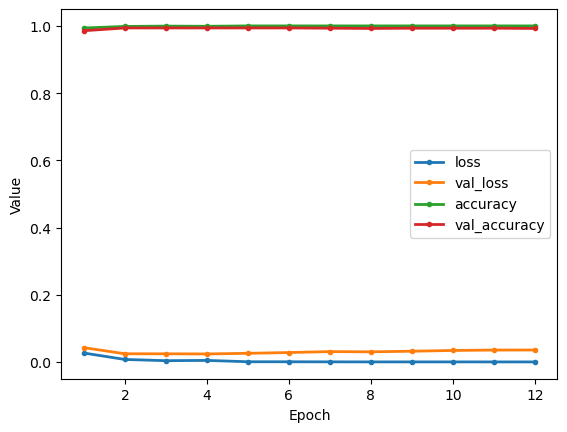

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

19/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,838,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,879,233 (148.31 MB)

 Trainable params: 38,879,233 (148.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:14 899ms/step - accuracy: 0.4531 - loss: 0.6932

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4727 - loss: 0.6931 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4870 - loss: 0.6930

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4932 - loss: 0.6929

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4958 - loss: 0.6929

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.4965 - loss: 0.6929

 7/84 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.4973 - loss: 0.6929 

 8/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.4974 - loss: 0.6929

 9/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.4960 - loss: 0.6929

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.4956 - loss: 0.6929

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.4957 - loss: 0.6929

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.4972 - loss: 0.6928

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.4993 - loss: 0.6928

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5017 - loss: 0.6927

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5045 - loss: 0.6926

16/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5070 - loss: 0.6925

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5090 - loss: 0.6924

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5106 - loss: 0.6923

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5117 - loss: 0.6922

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5125 - loss: 0.6921

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5134 - loss: 0.6920

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5148 - loss: 0.6918

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5166 - loss: 0.6917

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5189 - loss: 0.6915

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.5214 - loss: 0.6913

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5242 - loss: 0.6911

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5271 - loss: 0.6909

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5301 - loss: 0.6906

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5331 - loss: 0.6904

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5361 - loss: 0.6901

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5391 - loss: 0.6898

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5422 - loss: 0.6894

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.5452 - loss: 0.6891

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5482 - loss: 0.6887

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5514 - loss: 0.6883

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5546 - loss: 0.6879

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5578 - loss: 0.6874

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5610 - loss: 0.6869

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5641 - loss: 0.6864

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.5673 - loss: 0.6858

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5704 - loss: 0.6852

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5736 - loss: 0.6846

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5767 - loss: 0.6839

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5798 - loss: 0.6831

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5830 - loss: 0.6823

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5860 - loss: 0.6815

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5890 - loss: 0.6806

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5920 - loss: 0.6797

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5949 - loss: 0.6787

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5977 - loss: 0.6777

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.6006 - loss: 0.6767

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.6034 - loss: 0.6756

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6062 - loss: 0.6744

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6090 - loss: 0.6732

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6118 - loss: 0.6720

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6145 - loss: 0.6707

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6172 - loss: 0.6694

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.6198 - loss: 0.6680

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6225 - loss: 0.6666

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6250 - loss: 0.6651

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6276 - loss: 0.6636

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6301 - loss: 0.6621

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6326 - loss: 0.6605

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6350 - loss: 0.6588

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6374 - loss: 0.6571

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6398 - loss: 0.6554

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6422 - loss: 0.6537

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6445 - loss: 0.6519

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6468 - loss: 0.6501

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6491 - loss: 0.6482

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6513 - loss: 0.6464

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6535 - loss: 0.6445

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6557 - loss: 0.6425

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6578 - loss: 0.6406

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6599 - loss: 0.6386

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6620 - loss: 0.6367

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6641 - loss: 0.6347

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6661 - loss: 0.6327

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6682 - loss: 0.6306

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6702 - loss: 0.6286

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6721 - loss: 0.6265

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6741 - loss: 0.6245

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6760 - loss: 0.6224

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6778 - loss: 0.6204

84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.6797 - loss: 0.6184 - val_accuracy: 0.9910 - val_loss: 0.0406


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 1.0000 - loss: 0.0302

 2/84 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 0.0272

 3/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 1.0000 - loss: 0.0264

 4/84 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 0.0253

 5/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9994 - loss: 0.0256

 6/84 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.9986 - loss: 0.0262

 7/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9982 - loss: 0.0264

 8/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9979 - loss: 0.0265

 9/84 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9978 - loss: 0.0264

10/84 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9977 - loss: 0.0262

11/84 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9976 - loss: 0.0260

12/84 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9976 - loss: 0.0257

13/84 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.9976 - loss: 0.0254

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9976 - loss: 0.0252

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.9976 - loss: 0.0249

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9977 - loss: 0.0246

17/84 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9977 - loss: 0.0243

18/84 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.9977 - loss: 0.0239

19/84 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9977 - loss: 0.0238

20/84 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9977 - loss: 0.0236

21/84 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.9977 - loss: 0.0234

22/84 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.9977 - loss: 0.0233

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9976 - loss: 0.0231

24/84 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.9976 - loss: 0.0230

25/84 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.9975 - loss: 0.0229

26/84 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9975 - loss: 0.0228

27/84 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9975 - loss: 0.0227

28/84 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9975 - loss: 0.0226

29/84 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9975 - loss: 0.0225

30/84 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9974 - loss: 0.0224

31/84 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9974 - loss: 0.0224

32/84 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9973 - loss: 0.0223

33/84 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9973 - loss: 0.0223

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9973 - loss: 0.0222 

35/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9973 - loss: 0.0221

36/84 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9972 - loss: 0.0220

37/84 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9972 - loss: 0.0220

38/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9972 - loss: 0.0219

39/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9972 - loss: 0.0218

40/84 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9971 - loss: 0.0218

41/84 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9971 - loss: 0.0217

42/84 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9971 - loss: 0.0217

43/84 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9970 - loss: 0.0216

44/84 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9970 - loss: 0.0215

45/84 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9970 - loss: 0.0214

46/84 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9970 - loss: 0.0214

47/84 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9970 - loss: 0.0213

48/84 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9970 - loss: 0.0212

49/84 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9970 - loss: 0.0211

50/84 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9969 - loss: 0.0210

51/84 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9969 - loss: 0.0209

52/84 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9969 - loss: 0.0209

53/84 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9969 - loss: 0.0208

54/84 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9969 - loss: 0.0207

55/84 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.9969 - loss: 0.0206

56/84 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9969 - loss: 0.0205

57/84 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9969 - loss: 0.0204

58/84 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9969 - loss: 0.0204

59/84 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9969 - loss: 0.0203

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9969 - loss: 0.0202

61/84 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9969 - loss: 0.0201

62/84 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9969 - loss: 0.0200

63/84 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9969 - loss: 0.0199

64/84 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9969 - loss: 0.0198

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9969 - loss: 0.0198

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9969 - loss: 0.0197

67/84 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9969 - loss: 0.0196

68/84 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9969 - loss: 0.0195

69/84 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.9969 - loss: 0.0194

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9969 - loss: 0.0193

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9969 - loss: 0.0193

72/84 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9969 - loss: 0.0192

73/84 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9969 - loss: 0.0192

74/84 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9969 - loss: 0.0191

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9969 - loss: 0.0190

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9969 - loss: 0.0190

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9969 - loss: 0.0189

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9969 - loss: 0.0189

79/84 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9969 - loss: 0.0188

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9969 - loss: 0.0188

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9969 - loss: 0.0187

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9969 - loss: 0.0187

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9969 - loss: 0.0186

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9969 - loss: 0.0186

84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.9969 - loss: 0.0185 - val_accuracy: 0.9977 - val_loss: 0.0135


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 32s 387ms/step - accuracy: 1.0000 - loss: 0.0040

 2/84 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 1.0000 - loss: 0.0032

 3/84 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 1.0000 - loss: 0.0030

 4/84 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 1.0000 - loss: 0.0029

 5/84 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 1.0000 - loss: 0.0028

 6/84 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 1.0000 - loss: 0.0027

 7/84 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 1.0000 - loss: 0.0027

 8/84 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 1.0000 - loss: 0.0027

 9/84 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 0.0027

10/84 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 0.0027

11/84 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - accuracy: 1.0000 - loss: 0.0027

12/84 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 0.0026

13/84 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 1.0000 - loss: 0.0026

14/84 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 1.0000 - loss: 0.0026

15/84 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 0.0026

16/84 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 1.0000 - loss: 0.0026

17/84 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 1.0000 - loss: 0.0026

18/84 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 1.0000 - loss: 0.0026

19/84 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 1.0000 - loss: 0.0026

20/84 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 1.0000 - loss: 0.0026

21/84 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 1.0000 - loss: 0.0026

22/84 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 1.0000 - loss: 0.0026

23/84 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 1.0000 - loss: 0.0026

24/84 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 1.0000 - loss: 0.0026

25/84 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 1.0000 - loss: 0.0025

26/84 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 1.0000 - loss: 0.0025

27/84 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 1.0000 - loss: 0.0025

28/84 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 1.0000 - loss: 0.0025

29/84 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 1.0000 - loss: 0.0025

30/84 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 1.0000 - loss: 0.0025

31/84 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 1.0000 - loss: 0.0025

32/84 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 1.0000 - loss: 0.0025

33/84 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 1.0000 - loss: 0.0025

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 1.0000 - loss: 0.0025 

35/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 1.0000 - loss: 0.0025

36/84 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9999 - loss: 0.0025

37/84 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.9999 - loss: 0.0025

38/84 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.9999 - loss: 0.0025

39/84 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9999 - loss: 0.0025

40/84 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9999 - loss: 0.0025

41/84 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9999 - loss: 0.0025

42/84 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9999 - loss: 0.0025

43/84 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9999 - loss: 0.0025

44/84 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9999 - loss: 0.0025

45/84 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9999 - loss: 0.0025

46/84 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9999 - loss: 0.0025

47/84 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9999 - loss: 0.0025

48/84 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9999 - loss: 0.0025

49/84 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9999 - loss: 0.0025

50/84 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9999 - loss: 0.0025

51/84 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9999 - loss: 0.0025

52/84 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9999 - loss: 0.0025

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9999 - loss: 0.0025

54/84 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9999 - loss: 0.0025

55/84 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9998 - loss: 0.0025

56/84 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9998 - loss: 0.0025

57/84 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9998 - loss: 0.0025

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

61/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

62/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

63/84 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9998 - loss: 0.0025

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9998 - loss: 0.0025

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9998 - loss: 0.0025

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9998 - loss: 0.0025

67/84 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9998 - loss: 0.0025

68/84 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9998 - loss: 0.0025

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9998 - loss: 0.0025

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9998 - loss: 0.0025

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9998 - loss: 0.0025

72/84 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9998 - loss: 0.0025

73/84 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9998 - loss: 0.0025

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9998 - loss: 0.0025

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9998 - loss: 0.0025

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9998 - loss: 0.0025

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9998 - loss: 0.0025

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9998 - loss: 0.0025

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9998 - loss: 0.0025

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9998 - loss: 0.0024

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9998 - loss: 0.0024

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9998 - loss: 0.0024

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9998 - loss: 0.0024

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9998 - loss: 0.0024

84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9977 - val_loss: 0.0116


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 1.0000 - loss: 4.2097e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 1.0000 - loss: 4.6327e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 1.0000 - loss: 5.1048e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 1.0000 - loss: 5.7302e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 1.0000 - loss: 6.1808e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 1.0000 - loss: 6.4906e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 1.0000 - loss: 6.7155e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 1.0000 - loss: 6.8895e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 1.0000 - loss: 7.0561e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 1.0000 - loss: 7.1914e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 1.0000 - loss: 7.3306e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 1.0000 - loss: 7.4493e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 1.0000 - loss: 7.5354e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 1.0000 - loss: 7.6221e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 1.0000 - loss: 7.6936e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 1.0000 - loss: 7.7404e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 1.0000 - loss: 7.7851e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 1.0000 - loss: 7.8252e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 1.0000 - loss: 7.8581e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 1.0000 - loss: 7.8762e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 1.0000 - loss: 7.8887e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 1.0000 - loss: 7.8915e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 1.0000 - loss: 7.8914e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 1.0000 - loss: 7.8861e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 1.0000 - loss: 7.8819e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 1.0000 - loss: 7.9036e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 1.0000 - loss: 7.9187e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 1.0000 - loss: 7.9257e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 1.0000 - loss: 7.9270e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 1.0000 - loss: 7.9242e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 7.9335e-04 

32/84 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 7.9447e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 7.9626e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 8.0018e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 8.0369e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.0000 - loss: 8.0659e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 1.0000 - loss: 8.0915e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.0000 - loss: 8.1117e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.0000 - loss: 8.1288e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.0000 - loss: 8.1426e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 1.0000 - loss: 8.1526e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 1.0000 - loss: 8.1594e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 1.0000 - loss: 8.1655e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 1.0000 - loss: 8.1823e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 8.2010e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 8.2176e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 8.2332e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 8.2481e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 8.2604e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 8.2698e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 1.0000 - loss: 8.2793e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 8.2882e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 8.2956e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 8.3010e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 8.3044e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 1.0000 - loss: 8.3057e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 1.0000 - loss: 8.3051e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 1.0000 - loss: 8.3035e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 1.0000 - loss: 8.3032e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 1.0000 - loss: 8.3019e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 1.0000 - loss: 8.3013e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 1.0000 - loss: 8.3001e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 8.2974e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 8.2938e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 8.2892e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 1.0000 - loss: 8.2843e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 1.0000 - loss: 8.2785e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 1.0000 - loss: 8.2715e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 1.0000 - loss: 8.2636e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 1.0000 - loss: 8.2548e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 1.0000 - loss: 8.2989e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 1.0000 - loss: 8.3405e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 1.0000 - loss: 8.3791e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 8.4152e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 8.4553e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 8.4936e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 8.5294e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 8.5630e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 8.5963e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 8.6315e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 8.6649e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 8.6965e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 1.0000 - loss: 8.7267e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - loss: 8.7559e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 1.0000 - loss: 8.7844e-04 - val_accuracy: 0.9970 - val_loss: 0.0114


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 1.0000 - loss: 8.6451e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 1.0000 - loss: 0.0011    

 3/84 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 1.0000 - loss: 0.0011

 4/84 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 1.0000 - loss: 0.0010

 5/84 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 1.0000 - loss: 9.6095e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 1.0000 - loss: 9.2709e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 1.0000 - loss: 8.9405e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 1.0000 - loss: 8.6137e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 1.0000 - loss: 8.3810e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 1.0000 - loss: 8.1574e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 1.0000 - loss: 7.9472e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 1.0000 - loss: 7.7861e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 1.0000 - loss: 7.6386e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 1.0000 - loss: 7.5074e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 1.0000 - loss: 7.3865e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 1.0000 - loss: 7.2678e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 1.0000 - loss: 7.1537e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 1.0000 - loss: 7.0437e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 1.0000 - loss: 6.9341e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 1.0000 - loss: 6.8272e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 1.0000 - loss: 6.7255e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 1.0000 - loss: 6.6296e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 1.0000 - loss: 6.5389e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 1.0000 - loss: 6.4501e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 1.0000 - loss: 6.3652e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 1.0000 - loss: 6.2847e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 1.0000 - loss: 6.2072e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 1.0000 - loss: 6.1350e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 1.0000 - loss: 6.0704e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 1.0000 - loss: 6.0074e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 1.0000 - loss: 5.9458e-04 

32/84 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 1.0000 - loss: 5.8858e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 1.0000 - loss: 5.8288e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 1.0000 - loss: 5.7736e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 1.0000 - loss: 5.7198e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 1.0000 - loss: 5.6686e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 1.0000 - loss: 5.7063e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 1.0000 - loss: 5.7386e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 1.0000 - loss: 5.7667e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 1.0000 - loss: 5.7915e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.8136e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.8330e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 1.0000 - loss: 5.8490e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.8627e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.8738e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 1.0000 - loss: 5.8824e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 5.8907e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 5.8968e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 5.9021e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 1.0000 - loss: 5.9078e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 1.0000 - loss: 5.9125e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 5.9165e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 5.9198e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 1.0000 - loss: 5.9220e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 1.0000 - loss: 5.9259e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 5.9282e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 1.0000 - loss: 5.9294e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 1.0000 - loss: 5.9297e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 1.0000 - loss: 5.9289e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 1.0000 - loss: 5.9271e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 1.0000 - loss: 5.9261e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 1.0000 - loss: 5.9244e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 1.0000 - loss: 5.9218e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 1.0000 - loss: 5.9191e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 1.0000 - loss: 5.9168e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 1.0000 - loss: 5.9145e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 1.0000 - loss: 5.9114e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 1.0000 - loss: 5.9080e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 1.0000 - loss: 5.9061e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 1.0000 - loss: 5.9035e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 1.0000 - loss: 5.9015e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 1.0000 - loss: 5.8988e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 1.0000 - loss: 5.8955e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 5.8918e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 5.8874e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 5.8826e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 5.8779e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 1.0000 - loss: 5.8727e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 5.8677e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 5.8623e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 5.8565e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 1.0000 - loss: 5.8503e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 5.8436e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 5.8371e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 1.0000 - loss: 5.8307e-04 - val_accuracy: 0.9977 - val_loss: 0.0123


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - accuracy: 1.0000 - loss: 2.5987e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 1.0000 - loss: 2.3948e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 1.0000 - loss: 2.2722e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 1.0000 - loss: 2.3804e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 1.0000 - loss: 2.4446e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 1.0000 - loss: 2.4629e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 1.0000 - loss: 2.4548e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 1.0000 - loss: 2.4448e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 1.0000 - loss: 2.4256e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 1.0000 - loss: 2.4034e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 1.0000 - loss: 2.4156e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 1.0000 - loss: 2.4225e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 1.0000 - loss: 2.4247e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 1.0000 - loss: 2.4203e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 1.0000 - loss: 2.4145e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 1.0000 - loss: 2.4126e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 1.0000 - loss: 2.4091e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 1.0000 - loss: 2.4052e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 1.0000 - loss: 2.3999e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 1.0000 - loss: 2.3928e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 1.0000 - loss: 2.3923e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 1.0000 - loss: 2.3906e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 2.3929e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 1.0000 - loss: 2.3929e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 1.0000 - loss: 2.3914e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 1.0000 - loss: 2.3888e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 1.0000 - loss: 2.3856e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 1.0000 - loss: 2.3820e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 1.0000 - loss: 2.3797e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 1.0000 - loss: 2.3758e-04 

31/84 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 1.0000 - loss: 2.3714e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 1.0000 - loss: 2.3682e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 1.0000 - loss: 2.3642e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 1.0000 - loss: 2.3595e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 1.0000 - loss: 2.3553e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 1.0000 - loss: 2.3511e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 1.0000 - loss: 2.3477e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 1.0000 - loss: 2.3444e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 1.0000 - loss: 2.3411e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 1.0000 - loss: 2.3372e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 1.0000 - loss: 2.3325e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 1.0000 - loss: 2.3280e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 1.0000 - loss: 2.3230e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 1.0000 - loss: 2.3183e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 1.0000 - loss: 2.3135e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 2.3085e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 2.3033e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 2.2981e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 2.2927e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 1.0000 - loss: 2.2872e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 1.0000 - loss: 2.2817e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 1.0000 - loss: 2.2762e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 1.0000 - loss: 2.2707e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 1.0000 - loss: 2.2653e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 1.0000 - loss: 2.2598e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 1.0000 - loss: 2.2543e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 1.0000 - loss: 2.2489e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 1.0000 - loss: 2.2434e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 1.0000 - loss: 2.2381e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 1.0000 - loss: 2.2332e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 1.0000 - loss: 2.2284e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 1.0000 - loss: 2.2237e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 1.0000 - loss: 2.2190e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 2.2141e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 2.2092e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 2.2043e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 2.1994e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 2.1952e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 2.1919e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 2.1887e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 2.1855e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.1825e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.1794e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.1762e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 1.0000 - loss: 2.1730e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 1.0000 - loss: 2.1698e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 1.0000 - loss: 2.1666e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 2.1634e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 2.1603e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 2.1571e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 2.1541e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 2.1518e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 2.1494e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 2.1471e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 1.0000 - loss: 2.1449e-04 - val_accuracy: 0.9977 - val_loss: 0.0135


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 1.0000 - loss: 8.3521e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 9.7558e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.1777e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.2906e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3503e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3650e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.3578e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 1.3422e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.3769e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.3937e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.4125e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.4275e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.4371e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 1.4418e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.4455e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.4478e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.4488e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.4479e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4451e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4430e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.4513e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.4569e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.4695e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.4801e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.4893e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.4967e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.5023e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.5068e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.5104e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.5134e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5154e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5171e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5179e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5184e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5215e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.5268e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.5330e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.5387e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5462e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5532e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5595e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5648e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5694e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.5733e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5766e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5794e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5829e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5857e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5881e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5901e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5919e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5933e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5945e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5953e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5959e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.5966e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.5974e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5991e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6004e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6017e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6027e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6034e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.6040e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6043e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6047e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6050e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6051e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6052e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6050e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.6048e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6047e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6044e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6039e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6038e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6035e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6032e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.6027e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.6024e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.6020e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.6015e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.6010e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.6007e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.6003e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 1.6000e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 1.0000 - loss: 1.5996e-04 - val_accuracy: 0.9977 - val_loss: 0.0130


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - accuracy: 1.0000 - loss: 7.3592e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 1.0000 - loss: 7.7793e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 7.4820e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 1.0000 - loss: 8.6108e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 9.2279e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 9.4615e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 1.0090e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 1.0424e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 1.0587e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 1.0714e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.0786e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.0842e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.0885e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 1.0000 - loss: 1.0933e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.0956e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 1.0000 - loss: 1.0976e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 1.0987e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 1.0980e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 1.0957e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 1.0922e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 1.0000 - loss: 1.0878e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 1.0000 - loss: 1.0830e-04 

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 1.0000 - loss: 1.0777e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 1.0000 - loss: 1.0725e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 1.0000 - loss: 1.0677e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 1.0000 - loss: 1.0654e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 1.0000 - loss: 1.0640e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 1.0000 - loss: 1.0640e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 1.0000 - loss: 1.0661e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 1.0000 - loss: 1.0682e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 1.0000 - loss: 1.0705e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 1.0000 - loss: 1.0727e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0751e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0767e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0777e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0786e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0790e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0800e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.0810e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.0817e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.0824e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.0829e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.0837e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.0844e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 1.0000 - loss: 1.0849e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0853e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0854e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0853e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0851e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0847e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.0843e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 1.0839e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 1.0835e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.0833e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.0831e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.0828e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.0824e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.0819e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0812e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0805e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0796e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0788e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0779e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.0770e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 1.0763e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 1.0756e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 1.0750e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 1.0742e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 1.0000 - loss: 1.0734e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 1.0725e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0716e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0706e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0696e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0687e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0686e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0683e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 1.0000 - loss: 1.0681e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 1.0678e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 1.0677e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 1.0675e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 1.0672e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 1.0670e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 1.0669e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 1.0000 - loss: 1.0669e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 1.0000 - loss: 1.0668e-04 - val_accuracy: 0.9977 - val_loss: 0.0138


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 1.0000 - loss: 3.7853e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.6993e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 4.8942e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4720e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 5.9391e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 6.1452e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 6.2627e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 6.3976e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 6.5366e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 6.6886e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.7884e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 6.8760e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 6.9385e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 6.9844e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 7.0194e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 7.0445e-05 

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 7.0679e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 7.0833e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 7.0953e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 7.1089e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.1119e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.1112e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.1107e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.1062e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.1488e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.2140e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.2734e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.3216e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.3594e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.3920e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.4170e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.4562e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 7.4908e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.5289e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.5597e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.5859e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.6100e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6290e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 7.6536e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6738e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6899e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.7106e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.7274e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7429e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7571e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7710e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7821e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7913e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.7984e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.8041e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8102e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8146e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8208e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8251e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8289e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8311e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8326e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8341e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8347e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8348e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8339e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8328e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8340e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8352e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8353e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8350e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8342e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8338e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8333e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.8326e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8314e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8298e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8311e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8315e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8322e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.8332e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 7.8334e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8357e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8373e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8385e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8390e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8410e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8429e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.8445e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 7.8462e-05 - val_accuracy: 0.9977 - val_loss: 0.0135


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 1.0000 - loss: 7.5609e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 6.1728e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 8.2614e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 8.7863e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 9.0488e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 9.0449e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 8.9083e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 8.7878e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 8.6444e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 8.4868e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 8.3141e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 8.1605e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 8.0861e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 8.0037e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 7.9137e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 7.8269e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 7.7414e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 7.6593e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.5815e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.5014e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 7.4282e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.3573e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.2879e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.2285e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.1723e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 7.1196e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 7.0686e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 7.0177e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 6.9767e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 6.9347e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 6.8938e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 6.8532e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 6.8117e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 6.8031e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.7922e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.7812e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.7700e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.7599e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7482e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7378e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7335e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7274e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7229e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 6.7164e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 6.7086e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 6.6996e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 6.6902e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 6.6805e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 6.6700e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 6.6601e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 6.6493e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 6.6387e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 6.6282e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 6.6178e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 6.6069e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 6.5985e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 6.5894e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5799e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5698e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5592e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5483e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5372e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5260e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 6.5154e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 6.5051e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 6.4942e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 6.4831e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 6.4718e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 1.0000 - loss: 6.4601e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 6.4489e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.4378e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.4268e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.4157e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.4044e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.3931e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.3826e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 6.3722e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3618e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3510e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3399e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3285e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3201e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3146e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 6.3091e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 6.3037e-05 - val_accuracy: 0.9977 - val_loss: 0.0144


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 1.0000 - loss: 3.1838e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 4.8678e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 4.9136e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 4.7409e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 4.6085e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 4.5135e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 4.4271e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 4.4839e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.5464e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.5794e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.5952e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.5906e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.5700e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.5849e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 4.5877e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 4.5791e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5647e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5624e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5515e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5366e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5186e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5154e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.5219e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5225e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5205e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5169e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5129e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5095e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.5057e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.4996e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.4942e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.4865e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.4773e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.4667e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.4566e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 4.4469e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4401e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4340e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4272e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4208e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4137e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4084e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 4.4020e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3949e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3869e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3782e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3723e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3660e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3595e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.3521e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3447e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3371e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3293e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3211e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3191e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3162e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3127e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3092e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3058e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3036e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3025e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3008e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3006e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.3000e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2991e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2977e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2957e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2934e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2911e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.2884e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2854e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2826e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2795e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2780e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2773e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.2767e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 4.2776e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2783e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2787e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2790e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2798e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2803e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2805e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.2808e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 4.2811e-05 - val_accuracy: 0.9977 - val_loss: 0.0145


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step - accuracy: 1.0000 - loss: 1.1570e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 8.9649e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 7.5010e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 6.6731e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 6.1553e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 5.7901e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 5.4980e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 5.3241e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 5.1657e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 5.0587e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 4.9708e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.8983e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.8444e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 4.7940e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.7426e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.6920e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 4.6479e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.6022e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.5650e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.5269e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.4915e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.4543e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 4.4172e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.3994e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.3801e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.3608e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.3407e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.3218e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.3024e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.2827e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2648e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2472e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2345e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 4.2203e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2054e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2136e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 4.2196e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2255e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2298e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2354e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2394e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2420e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 4.2438e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 4.2438e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 4.2443e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2452e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2461e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2465e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2462e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2449e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 1.0000 - loss: 4.2430e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2407e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2381e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2347e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2309e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2277e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 4.2241e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2200e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2201e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2219e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2227e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2242e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2253e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 4.2257e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2279e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2298e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2311e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2320e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2325e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 4.2324e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2327e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2330e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2328e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2321e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2312e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 4.2304e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 4.2294e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2281e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2265e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2253e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2238e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2219e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2199e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 1.0000 - loss: 4.2180e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 1.0000 - loss: 4.2162e-05 - val_accuracy: 0.9977 - val_loss: 0.0141



[Train Accuracy: 100.00% - Test Accuracy: 99.70%]


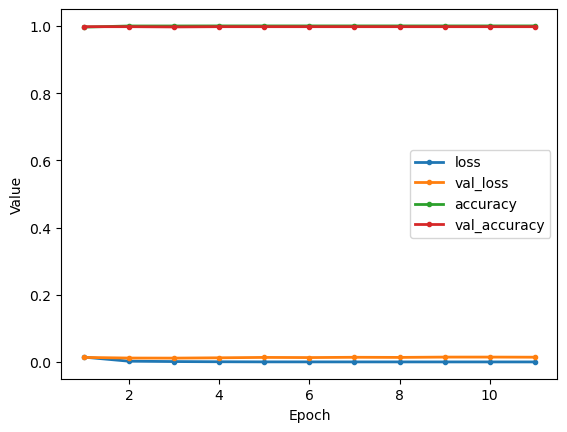

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step

 5/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/52 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step

 5/52 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

10/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

14/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

33/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/SBP/report_81MK7YAN.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################